In [171]:
using ITensors
using QuadGK
using StatsPlots
using LinearAlgebra
using JLD2
using Roots
using Base.Threads

In [17]:
rdm = [0.6 0.1-0.2im; 0.1+0.2im 0.4] 

2×2 Matrix{ComplexF64}:
 0.6+0.0im  0.1-0.2im
 0.1+0.2im  0.4+0.0im

In [2]:
function prob_density(x, rdm)
    state = [exp(1im * (3π/2) * x) * cospi(0.5 * x), exp(-1im * (2π/2) * x) * sinpi(0.5 * x)]
    return real(state' * rdm * state)
end

prob_density (generic function with 1 method)

In [14]:
function normalise_prob_density(rdm)
    prob_density_wrapper(x) = prob_density(x, rdm)
    norm_factor, _ = quadgk(prob_density_wrapper, 0, 1)
    return norm_factor
end

normalise_prob_density (generic function with 1 method)

In [18]:
norm_factor = normalise_prob_density(rdm)

0.5060630454511199

In [16]:
function cdf(x, rdm, norm_factor)
    # integrate the normalised pdf over the range of x from 0 to x prime
    prob_density_wrapper(x_prime) = prob_density(x_prime, rdm) / norm_factor
    cdf_value, _ = quadgk(prob_density_wrapper, 0, x)
    return cdf_value
end

cdf (generic function with 1 method)

In [51]:
function sample_state(rdm, norm_factor)
    u = rand()
    cdf_wrapper(x) = cdf(x, rdm, norm_factor) - u
    sampled_x = find_zero(cdf_wrapper, (0,1))
    sampled_state = [exp(1im * (3π/2) * sampled_x) * cospi(0.5 * sampled_x), exp(-1im * (2π/2) * sampled_x) * sinpi(0.5 * sampled_x)]
    return sampled_x, sampled_state
end

sample_state (generic function with 1 method)

In [52]:
rdm = [0.6 0.1-0.2im; 0.1+0.2im 0.4]
norm_factor = normalise_prob_density(rdm)
sampled_state = sample_state(rdm, norm_factor)

(0.03541513166484771, ComplexF64[0.9845807232599427 + 0.16585927207402im, 0.055257487444224575 - 0.006173437725914516im])

In [159]:
include("/Users/joshua/Documents/QuantumInspiredML/MPS_MSE/complex-opt/Julia/optim/utils.jl")

forecast_sites (generic function with 1 method)

In [149]:
mps0 = load_mps_from_h5("/Users/joshua/Documents/QuantumInspiredML/MPS_MSE/complex-opt/Julia/optim/chi_15_ecg_trial/mps0_ecg.h5", "mps0_ecg")
mps1 = load_mps_from_h5("/Users/joshua/Documents/QuantumInspiredML/MPS_MSE/complex-opt/Julia/optim/chi_15_ecg_trial/mps1_ecg.h5", "mps1_ecg")

MPS
[1] ((dim=2|id=562|"S=1/2,Site,n=1"), (dim=2|id=812|"Link,l=1"))
[2] ((dim=2|id=824|"S=1/2,Site,n=2"), (dim=4|id=473|"Link,l=2"), (dim=2|id=812|"Link,l=1"))
[3] ((dim=2|id=769|"S=1/2,Site,n=3"), (dim=8|id=387|"Link,l=3"), (dim=4|id=473|"Link,l=2"))
[4] ((dim=2|id=34|"S=1/2,Site,n=4"), (dim=15|id=589|"Link,l=4"), (dim=8|id=387|"Link,l=3"))
[5] ((dim=2|id=636|"S=1/2,Site,n=5"), (dim=15|id=634|"Link,l=5"), (dim=15|id=589|"Link,l=4"))
[6] ((dim=2|id=143|"S=1/2,Site,n=6"), (dim=15|id=380|"Link,l=6"), (dim=15|id=634|"Link,l=5"))
[7] ((dim=2|id=658|"S=1/2,Site,n=7"), (dim=15|id=913|"Link,l=7"), (dim=15|id=380|"Link,l=6"))
[8] ((dim=2|id=37|"S=1/2,Site,n=8"), (dim=15|id=732|"Link,l=8"), (dim=15|id=913|"Link,l=7"))
[9] ((dim=2|id=494|"S=1/2,Site,n=9"), (dim=15|id=574|"Link,l=9"), (dim=15|id=732|"Link,l=8"))
[10] ((dim=2|id=651|"S=1/2,Site,n=10"), (dim=15|id=883|"Link,l=10"), (dim=15|id=574|"Link,l=9"))
[11] ((dim=2|id=265|"S=1/2,Site,n=11"), (dim=15|id=49|"Link,l=11"), (dim=15|id=883|"Link,

In [154]:
@load "X_test_ecg.jld2"

2-element Vector{Symbol}:
 :X_test_scaled
 :y_test

In [155]:
class_0_test_idxs = findall(x -> x .== 0, y_test);
class_1_test_idxs = findall(x -> x .== 1, y_test);
class_0_test_samples = X_test_scaled[class_0_test_idxs, :]
class_1_test_samples = X_test_scaled[class_1_test_idxs, :];

In [163]:
interp_samps1000 = Matrix{Float64}(undef, 3000, 46);
@threads for i in 1:3000
    samp = forecast_sites(deepcopy(mps0), class_0_test_samples[9,1:50], 51);
    interp_samps1000[i, :] = samp
end

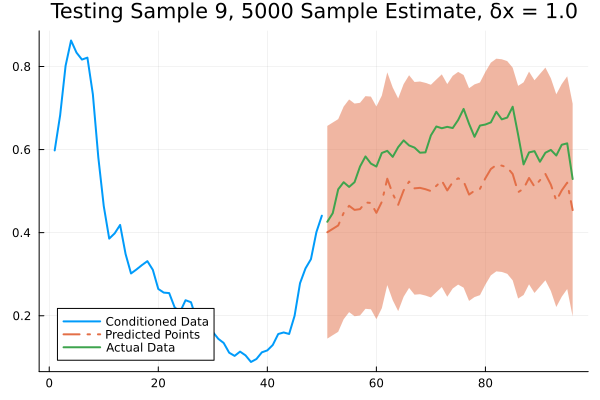

In [165]:
plot(collect(1:50), class_0_test_samples[9,1:50], lw=2, label="Conditioned Data", title="Testing Sample 9, 5000 Sample Estimate, δx = 1.0", legend=:bottomleft)
plot!(collect(51:96), mean(interp_samps1000, dims=1)[1,:], ribbon=std(interp_samps1000, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:96), class_0_test_samples[9, 51:96], label="Actual Data", lw=2)

In [167]:
function compute_smape(forecasted::Vector{Float64}, actual::Vector{Float64})
    @assert length(forecasted) == length(actual) "Time series lengths do not match"
    """Compute SMAPE (Symmetric Mean Absolute Percentage Error)"""
    abs_diff = abs.(forecasted .- actual)
    sum_abs_vals = abs.(actual) .+ abs.(forecasted)
    smape = mean(200*(abs_diff/sum_abs_vals))
    return smape
    
end

compute_smape (generic function with 1 method)

In [168]:
smapes_all_c1 = []
for i in 1:size(class_1_test_samples)[1]
    # get the sample and slice into 50% conditioning and 50% testing
    ground_truth_sample = class_1_test_samples[i,1:50]
    interp_samps = Matrix{Float64}(undef, 1000, 46);
    @threads for j in 1:1000
        samp = forecast_sites(deepcopy(mps1), ground_truth_sample, 51);
        interp_samps[j, :] = samp
    end
    predicted_sample = mean(interp_samps, dims=1)[1,:]
    # compute smape between forecasted and actual
    # actual 
    ground_truth_actual = class_1_test_samples[i,51:end]
    sm = compute_smape(predicted_sample, ground_truth_actual)
    push!(smapes_all_c1, sm)
    println("Sample $i : sMAPE: $sm")
end

Sample 1 : sMAPE: 0.2665101838084318
Sample 2 : sMAPE: 0.2907360520053406
Sample 3 : sMAPE: 0.3673615408667067
Sample 4 : sMAPE: 0.32348499516098644
Sample 5 : sMAPE: 0.3244426072869146
Sample 6 : sMAPE: 0.3991808906751419
Sample 7 : sMAPE: 0.36323532933252667
Sample 8 : sMAPE: 0.289276856544146
Sample 9 : sMAPE: 0.46351235194376533
Sample 10 : sMAPE: 0.332296327817134
Sample 11 : sMAPE: 0.3291328206768317
Sample 12 : sMAPE: 0.39739005357985685
Sample 13 : sMAPE: 0.552657179484941
Sample 14 : sMAPE: 0.27307637933377443
Sample 15 : sMAPE: 0.3677956429430169
Sample 16 : sMAPE: 0.27043607463733543
Sample 17 : sMAPE: 0.6095565071577546
Sample 18 : sMAPE: 0.476497794327092
Sample 19 : sMAPE: 0.3049891726769155
Sample 20 : sMAPE: 0.31428979352508635
Sample 21 : sMAPE: 0.47433126660342934
Sample 22 : sMAPE: 0.27449957888014703
Sample 23 : sMAPE: 0.4282458249330999
Sample 24 : sMAPE: 0.22324496812141165
Sample 25 : sMAPE: 0.43649052643119995
Sample 26 : sMAPE: 0.3753523238926096
Sample 27 : sM

In [173]:
smapes_all_c0 = []
for i in 1:size(class_0_test_samples)[1]
    # get the sample and slice into 50% conditioning and 50% testing
    ground_truth_sample = class_0_test_samples[i,1:50]
    interp_samps = Matrix{Float64}(undef, 1000, 46);
    @threads for j in 1:1000
        samp = forecast_sites(deepcopy(mps0), ground_truth_sample, 51);
        interp_samps[j, :] = samp
    end
    predicted_sample = mean(interp_samps, dims=1)[1,:]
    # compute smape between forecasted and actual
    # actual 
    ground_truth_actual = class_0_test_samples[i,51:end]
    sm = compute_smape(predicted_sample, ground_truth_actual)
    push!(smapes_all_c0, sm)
    println("Sample $i : sMAPE: $sm")
end

Sample 1 : sMAPE: 0.40963253198529076
Sample 2 : sMAPE: 0.24413665130876325
Sample 3 : sMAPE: 0.44514017997079214
Sample 4 : sMAPE: 0.5695276161041689
Sample 5 : sMAPE: 0.3759560784492288
Sample 6 : sMAPE: 0.703739114717295
Sample 7 : sMAPE: 0.4242472629409143
Sample 8 : sMAPE: 0.2638965259200272
Sample 9 : sMAPE: 0.4034655549419893
Sample 10 : sMAPE: 0.6042081294353016
Sample 11 : sMAPE: 0.2488493073691119
Sample 12 : sMAPE: 0.3939640647376705
Sample 13 : sMAPE: 0.3391677763400892
Sample 14 : sMAPE: 0.26295058301925545
Sample 15 : sMAPE: 0.446467118350484
Sample 16 : sMAPE: 0.36042946272232534
Sample 17 : sMAPE: 0.44228570145208723
Sample 18 : sMAPE: 0.2821944726890427
Sample 19 : sMAPE: 0.5184677971174039
Sample 20 : sMAPE: 0.39793097903300884
Sample 21 : sMAPE: 0.3684525230624139
Sample 22 : sMAPE: 0.587512723731383
Sample 23 : sMAPE: 0.19091078536553083
Sample 24 : sMAPE: 0.2790101779931562
Sample 25 : sMAPE: 0.3395715376296113
Sample 26 : sMAPE: 0.49061771677368604
Sample 27 : sMA

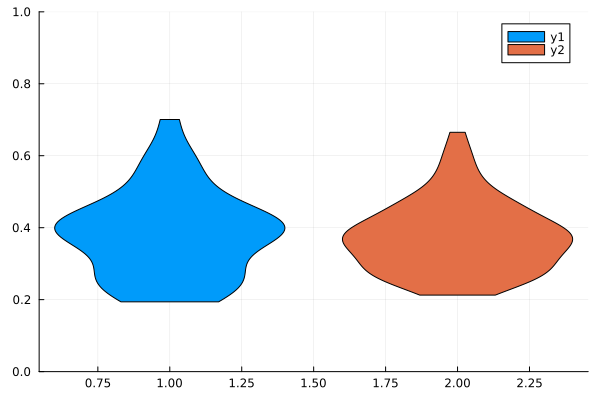

In [175]:
violin(smapes_all_c0, ylimit=(0,1))
violin!(smapes_all_c1)

In [179]:
argmin(smapes_all_c0)

23

In [180]:
interp_samps1000 = Matrix{Float64}(undef, 1000, 46);
@threads for i in 1:1000
    samp = forecast_sites(deepcopy(mps0), class_0_test_samples[23,1:50], 51);
    interp_samps1000[i, :] = samp
end